In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit 
using Plots, StatsPlots, LaTeXStrings
using DelimitedFiles, DataFrames
using Statistics
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
include("VirusLoadCurve.jl")
using .VirusLoadCurve

# Viral load data fitting



## Data set



In [4]:
filename = "../../data/Baccam2008/table1.csv"
temp = readdlm(filename, ',', Float64, '\n', header=true)
DATA = DataFrame(temp[1], Symbol.(temp[2][:]))

,Patient,1,2,3,4,5,6,7,8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,2.0,5.5,4.0,5.5,3.0,0.5,0.5,0.5
2,2.0,1.0,6.0,3.0,1.5,3.5,1.3,0.5,0.5
3,3.0,2.5,5.0,5.0,3.0,5.5,3.5,0.5,0.5
4,4.0,3.5,5.5,6.5,5.5,3.5,4.0,0.5,0.5
5,5.0,2.5,3.0,6.5,6.5,2.0,0.8,0.5,0.5
6,6.0,4.0,5.0,5.5,7.5,5.5,1.3,0.5,0.5


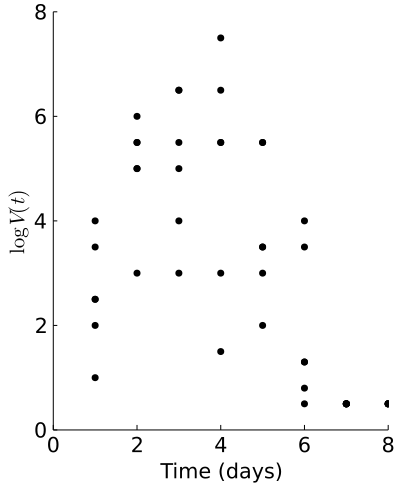

In [5]:
vlims = (0., 8)
plt = plot(legend=:none, ylims=vlims)
tdata = parse.(Float64, names(DATA)[2:end])
for k ∈ 1:size(DATA, 1)
    vdata = Array(DATA[k, 2:end])
    data = VirusLoadCurve.VirusLoadData(tdata, vdata)
    plot!(plt, data, size = (400, 500), color=:black)
end
display(plt)

## Fitting the standard virus load function to each individual in all groups (nasal swab)

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [6]:
results = []
tdata = parse.(Float64, names(DATA)[2:end])
for k ∈ 1:size(DATA, 1)
    vdata = Array(DATA[k, 2:end])
    data = VirusLoadCurve.VirusLoadData(tdata, vdata)
    resultVLF = VirusLoadCurve.fitVLF(data; ϵ=0.2)
    push!(results, resultVLF)
end

Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:27
Finding possible parameter values 100%|█████████████████| Time: 0:00:07


Number of possible parameters found: 323 (out of 1000000 testted)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:14
Finding possible parameter values 100%|█████████████████| Time: 0:00:07


Number of possible parameters found: 47147 (out of 1000000 testted)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:26
Finding possible parameter values 100%|█████████████████| Time: 0:00:07


Number of possible parameters found: 5198 (out of 1000000 testted)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:14
Finding possible parameter values 100%|█████████████████| Time: 0:00:07


Number of possible parameters found: 1034 (out of 1000000 testted)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:14
Finding possible parameter values 100%|█████████████████| Time: 0:00:07


Number of possible parameters found: 1484 (out of 1000000 testted)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:11
Finding possible parameter values 100%|█████████████████| Time: 0:00:07


Number of possible parameters found: 4598 (out of 1000000 testted)


In [7]:
using JLD2, FileIO
# save("Baccam2008Results.jld2", Dict("results" => results))
results = load("Baccam2008Results.jld2", "results");

In [8]:
io = IOBuffer(append=true)
function param_extrema(result)
    param_array = result.param_array
    param = result.fit.param
    if length(param_array)==0 return (param, param) end
    array = map(x -> map(y -> y[x], param_array), 1:length(param_array[1]))
    param_lower = map(minimum, array)
    param_upper = map(maximum, array)
    return (param_lower, param_upper)
end
print(io, @sprintf "\nData & \$\\log V_{\\max}\$ & \$a_1\$ & \$a_2\$ & \$\\alpha\$ & \$b_1\$ & \$b_2\$ & RSS \\\\ \n")
function VLFResultsLatex(dataname, result)
    print(io, @sprintf "%s & " dataname)
#     print(io, @sprintf "%.2f \$\\cdot 10^{%d}\$ & " 10^rem(result.fit.param[6], 1) floor(result.fit.param[6]))
    print(io, @sprintf "%.2f & " result.fit.param[6])
    print(io, @sprintf "%.2f & " result.fit.param[1])
    print(io, @sprintf "%.2f & " result.fit.param[2])
    print(io, @sprintf "%.2f & " result.fit.param[5])
    print(io, @sprintf "%.2f & " result.fit.param[3])
    print(io, @sprintf "%.2f & " result.fit.param[4])
    print(io, @sprintf "%.3f \\\\ \n" sum(abs2, result.fit.resid))
    lower, upper = param_extrema(result)
    print(io, @sprintf "  & ")
#     print(io, @sprintf "(%.2f \$\\cdot 10^{%d}\$, %.2f \$\\cdot 10^{%d}\$) & " 10^rem(lower[6], 1) floor(lower[6]) 10^rem(upper[6], 1) floor(upper[6]))
    print(io, @sprintf "(%.2f, %.2f) & " lower[6] upper[6])
    print(io, @sprintf "(%.2f, %.2f) & " lower[1] upper[1])
    print(io, @sprintf "(%.2f, %.2f) & " lower[2] upper[2])
    print(io, @sprintf "(%.2f, %.2f) & " lower[5] upper[5])
    print(io, @sprintf "(%.2f, %.2f) & " lower[3] upper[3])
    print(io, @sprintf "(%.2f, %.2f) & " lower[4] upper[4])
    print(io, @sprintf "\$\\leq\$ %.3f \\\\ \n" (1.0+0.1)*sum(abs2, result.fit.resid))
end

VLFResultsLatex (generic function with 1 method)

Patient 1: 
RSS = 1.50000e+00
a₁ = 1.0048756791786266, CI=

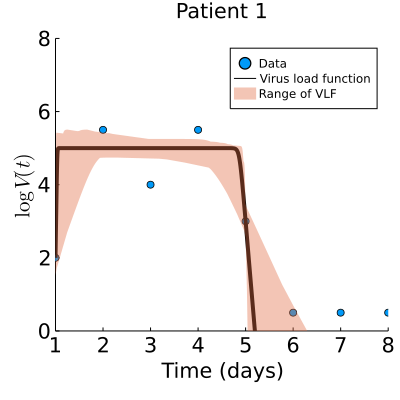

(0.9774540881820916, 1.2018559383119447)
a₂ = 1.06869311346014, CI=(1.0192482655947994, 2.7035928374987286)
b₁ = 4.70111404371748, CI=(3.109384783758168, 4.949050751570174)
b₂ = 5.039631034647331, CI=(5.005333472632738, 5.611170733647642)
α = 1.0e-8, CI=(1.0e-8, 0.8502681404191132)
logVmax = 5.000000000003851, CI=(4.742451811252755, 5.508109886058404)


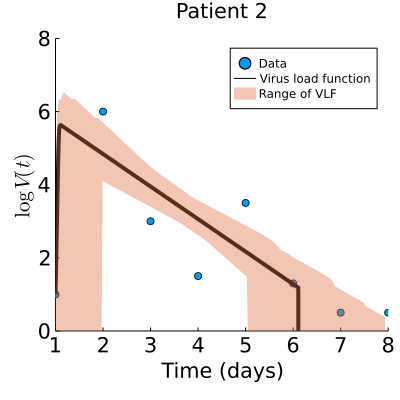




Patient 2: 
RSS = 6.45100e+00
a₁ = 1.0317042107684977, CI=(0.9735524256614202, 1.9963755560002938)
a₂ = 1.111495398966033, CI=(1.004511483541832, 2.417123492673566)
b₁ = 6.1091487594163825, CI=(2.851006965360482, 7.999731278229133)
b₂ = 6.1091487594163825, CI=(5.0105056319676216, 7.999964249915483)
α = 2.049300732185607, CI=(1.12431925579149, 2.895890371422701)
logVmax = 5.630769094103001, CI=(4.103688386979032, 6.56790755639932)


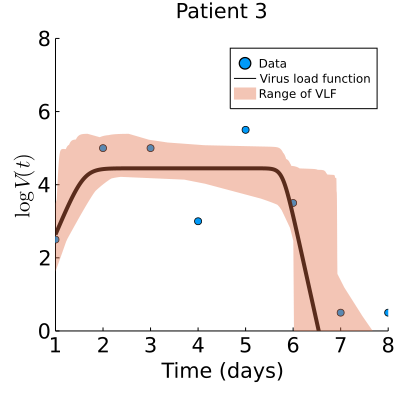




Patient 3: 
RSS = 3.98367e+00
a₁ = 0.7406726327238804, CI=(3.283942574372478e-5, 1.2110790008155565)
a₂ = 2.4279877693390004, CI=(1.016982793427916, 4.526269293574201)
b₁ = 5.338220269755044, CI=(3.727585409513344, 6.986217557533989)
b₂ = 6.225209027554111, CI=(6.008351213872173, 7.225250067863868)
α = 1.0000000000049032e-8, CI=(1.0000000000049032e-8, 1.2272450315008558)
logVmax = 4.44798768417582, CI=(4.159456855496608, 5.504851965791847)


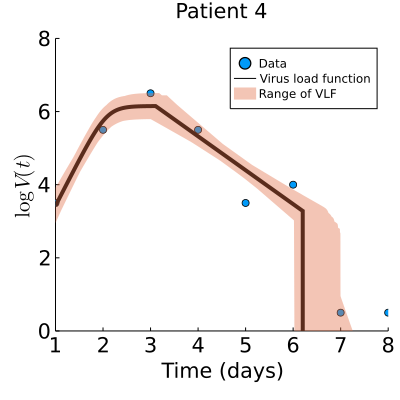




Patient 4: 
RSS = 1.30353e+00
a₁ = 1.0478198865397343, CI=(0.7489742830217447, 1.2718812533032189)
a₂ = 3.1061899704879496, CI=(2.7747577520001196, 3.546529582940481)
b₁ = 6.202133803538717, CI=(4.99022987367072, 6.994145403271351)
b₂ = 6.202133803538717, CI=(6.024342184330522, 7.43604776393129)
α = 2.1343682248316695, CI=(1.6544474471986235, 2.780610620573979)
logVmax = 6.151081813618693, CI=(5.796639588625175, 6.507791695460855)


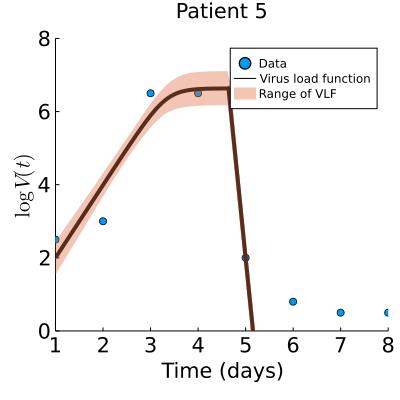




Patient 5: 
RSS = 1.69980e+00
a₁ = 2.018654285770345, CI=(1.7262622473607456, 2.2588268773262428)
a₂ = 4.64001296866128, CI=(4.576283198489132, 4.700796641181803)
b₁ = 6.657148517234147, CI=(4.668877785841192, 7.9966869300060734)
b₂ = 7.999980660284734, CI=(5.436308981289738, 7.999980660284734)
α = 29.63179296390395, CI=(27.925837054704854, 31.239984881857577)
logVmax = 6.63285303234603, CI=(6.169331766963415, 7.1054741524976235)


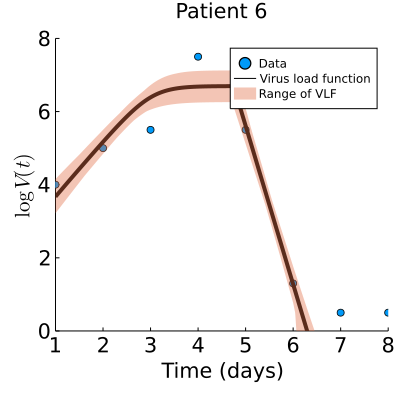




Patient 6: 
RSS = 1.60649e+00
a₁ = 1.2706579640359075, CI=(0.7227077204925214, 1.666085776670156)
a₂ = 4.750198283003672, CI=(4.568171927813787, 4.90606784668238)
b₁ = 7.2505393311088735, CI=(4.76407168709261, 7.99988480637445)
b₂ = 7.2505393311088735, CI=(6.083357796830345, 7.999980901106884)
α = 9.983404999793708, CI=(8.428976799663259, 11.502171691622877)
logVmax = 6.6963026751453985, CI=(6.258122610497374, 7.12605788673779)




Data & $V_{\max}$ & $a_1$ & $a_2$ & $\alpha$ & $b_1$ & $b_2$ & RSS \\ 
Patient 1 & 5.00 & 1.00 & 1.07 & 0.00 & 4.70 & 5.04 & 1.500 \\ 
  & (4.74, 5.51) & (0.98, 1.20) & (1.02, 2.70) & (0.00, 0.85) & (3.11, 4.95) & (5.01, 5.61) & $\leq$ 1.650 \\ 
Patient 2 & 5.63 & 1.03 & 1.11 & 2.05 & 6.11 & 6.11 & 6.451 \\ 
  & (4.10, 6.57) & (0.97, 2.00) & (1.00, 2.42) & (1.12, 2.90) & (2.85, 8.00) & (5.01, 8.00) & $\leq$ 7.096 \\ 
Patient 3 & 4.45 & 0.74 & 2.43 & 0.00 & 5.34 & 6.23 & 3.984 \\ 
  & (4.16, 5.50) & (0.00, 1.21) & (1.02, 4.53) & (0.00, 1.23) & (3.73, 6.99)

In [9]:
cases = "Patient ".*string.(Int.(DATA[:, 1]))
filename = "Baccam2008-"
for (resultVLF, case) ∈ zip(results, cases)
    println(case*": ")
    summary(resultVLF)
    VLFResultsLatex(case, resultVLF)
    pt = plot(resultVLF.data, size = (400, 400))
    plot!(pt, resultVLF)
    ylims!(pt, vlims)
    title!(pt, case)
    savefig(figdir*filename*replace(case, " " => "-")*".png")
    savefig(figdir*filename*replace(case, " " => "-")*".pdf")
    display(pt)
    println("\n\n")
end
print(read(io, String))
print(read(io, String))

In [10]:
function Boxplots(results)
    ndata = length(results)
    params = []
    for resultVLF ∈ results
        params = vcat(params, resultVLF.fit.param)
    end
    params = reshape(params, (6, ndata))
    param_names = results[1].names
    pt1 = plot(yaxis=("Time (days)", extrema(params[1:4, :]) .+ (-0.5, 0.5), font(14)), 
        xaxis=("Parameter", font(14)), 
        grid=false, legend=false, left_margin = 5Plots.mm, right_margin = 16Plots.mm)
    [boxplot!(pt1, repeat([param_names[i]], ndata), params[i, :], fillalpha=0.7, lw=2, color=1) for i = 1:4]
    [dotplot!(pt1, repeat([param_names[i]], ndata), params[i, :], marker=(:black, stroke(0))) for i = 1:4]
    pt2 = twinx()
    plot!(pt2, yaxis=("Decay rate (1/days)", extrema(params[5, :]) .+ (-0.2, 0.2), font(14)), 
        xaxis=("", font(14)), 
        grid=false, legend=false, left_margin = 5Plots.mm, right_margin = 16Plots.mm)
    boxplot!(pt2, repeat([param_names[5]], ndata), params[5, :], fillalpha=0.7, lw=2, color=2)
    dotplot!(pt2, repeat([param_names[5]], ndata), params[5, :], marker=(:black, stroke(0)))
    pt1
end

Boxplots (generic function with 1 method)

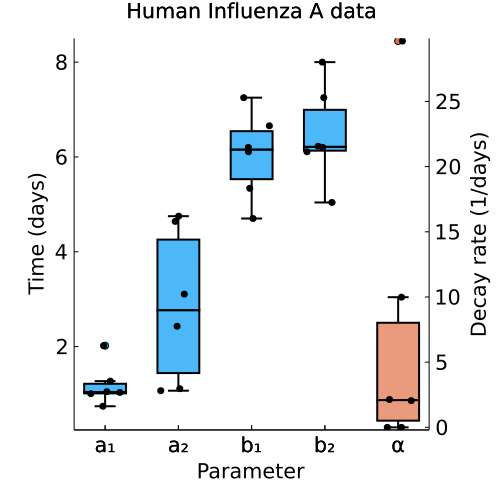

In [11]:
text_data = "Human Influenza A data"
text_file = "Baccam2008-Boxplot"
pt = Boxplots(results)
plot!(title = text_data, size=(500, 500))
savefig(figdir*text_file*".pdf")
savefig(figdir*text_file*".png")
display(pt)